(sec:intro)=
# Uvod v procesiranje signalov

V tem uvodnem poglavju, bomo poskušali v grobem očrtati motivacijo za to knjigo in tudi vsebino, ki jo lahko pričakujete v sledečih poglavjih.

## Kaj je procesiranje signalov?
Termin *procesiranje signalov* uporabljamo za označitev različnih metod obdelave izmerjenih podatkov z namenom, da razkrijemo informacije skritev v takih meritvah. S procesiranjem signalom želimo identificirati/karakterizirati različne fizikalne procese, kot primer takih procesov lahko vidimo klasične inženirske izzive (npr.: napake na ležajih, dinamske lastnosti struktur), pa tudi izzive v biologiji (npr.: sekvenciranje genoma), astronomiji (npr.: merjenje črne luknje), družboslovju (npr.: širjenje corona virusa) in podobno.

Kot primer si lahko pogledamo meritve na novem/poškodovanem ležaju (za podrobnosti, glejte vir {cite:t}`slavic2011typical`). Slika spodaj prikazuje meritev sile na dobrem in dveh poškodovanih ležajih. V meritvah vidimo določene razlike, ampak ali lahko iz meritev identificiramo *tip* poškodbe? Nadalje ali lahko iz meritev identificiramo *velikost* poškodbe? Na ta in podobna vprašanja bomo poskušali odgovoriti tekom te knjige.

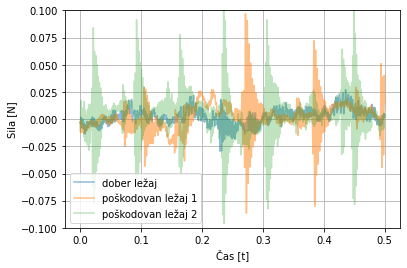

In [1]:
import numpy as np
import matplotlib.pyplot as plt

new = np.load('./data/bearing/new 1A.npy')
radial = np.load('./data/bearing/radial Low 1A.npy')
contamination = np.load('./data/bearing/contam low 2A.npy')
time = np.arange(len(new)) * 1./5000

sel = time<0.5
plt.plot(time[sel], new[sel, 2], alpha=0.5, label='dober ležaj')
plt.plot(time[sel], radial[sel, 2], alpha=0.5, label='poškodovan ležaj 1')
plt.plot(time[sel], contamination[sel, 2], alpha=0.3, label='poškodovan ležaj 2')
plt.xlabel('Čas [t]')
plt.ylabel('Sila [N]')
plt.ylim(-0.1, 0.1)
plt.grid()
plt.legend();

Kot naslednji primer, je spodaj prikazana slika frekvenčne prenosne funkcije (*ang.* FRF, Frequency Response Function), ki za linearni časovno invariantni sistem (glejte poglavje {ref}`sec:konvolucija_LTI`) v frekvenčni domeni povezuje vzbujanje sistema z njegovim odzivom (primer je vzet iz paketa pyUFF). Zadnji stavek vsebuje veliko terminov, ki jih v nadaljevanju razdelali in spoznali. Pravilna identifikacija frekvenčne prenosne funkcije je zelo pomembna za karakterizacijo dinamskih sistemov in kako jo pravilno identificiramo bomo v celoti razumeli šele proti koncu te knjige.

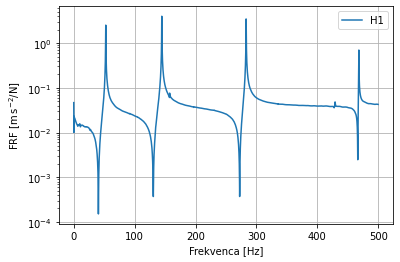

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pyuff

uff = pyuff.UFF('./data/uff/beam.uff').read_sets(setn=4)
fr = uff['x']
H1 = uff['data']

sel = fr<500
plt.semilogy(fr[sel], np.abs(H1[sel]), label='H1')
plt.xlabel('Frekvenca [Hz]')
plt.ylabel('FRF [m$\,$s$^{-2}$/N]')
plt.grid()
plt.legend();

## Kaj je sistem?

Dinamske in druge sisteme ponavadi poskušamo opisati na podlagi modelov; parametre modelov pa identificirati s procesiranjem signalov. Spodnja slika prikazuje poljuben sistem, katerega vzbujanje opišemo v času s $x(t)$, odziv pa s $y(t)$. Kot primer vzbujanja $x(t)$ sistema si lahko predstavljamo silo, ki deluje na neko maso, kot odziv $y(t)$ pa napetost na zaznavalu pospeška ali zvočnega tlaka. Odziv je ponavadi res napetost, ki je ponavadi proporcionalna neki merjeni veličini (npr.: pospešek, zvočni tlak), vendar pa je odziv lahko povezan tudi npr. z intenziteto slikovnega elementa v sliki (glejte {cite:t}`gorjup2021still`). 

![sistem-in-out](./images/sistem-in-out.svg)

Tukaj se bomo omejili na takšne sisteme kjer je odziv rezultat preteklega in trenutnega vzbujanja (takšnim sistemom rečemo, da so *kavzalni*). Podobno se bomo omejili samo na takšne sisteme, kjer odziv ne vpliva nazaj na vzbujanje. Nadalje bomo v začetku predpostavili, da imamo samo eno vzbujanje in samo en odziv.

## Kaj linearni časovno invariantni sistem?

Ta knjiga bo osredotočena samo na linearne časovno invariantne (LČI) sisteme (ang. *linear time invariant systems*, pogosto tudi *LTI systems*). Podrobneje si bomo take sisteme pogledali v poglavju {ref}`sec:konvolucija_LTI`, tukaj, v uvodu, se jih bomo zgoj dotaknili. LČI sistemi se na idealni impulz odzovejo z impulznim odzivom, ki ga oznalimo s $h(t)$. Vzbujanje $x(t)$ in odziv $y(t)$ so za LČI sistemo povezani z:

$$
y(t)=h(t) * x(t),
$$

kjer znak $*$ označuje matematično operacijo konvolucije. Ker je sistem linearen, bo sprememba na strani vzbujanja vodilo v proporcionalno spremembo na strani odziva:

$$
k\,y(t)=h(t) * (k\,x(t)),
$$

ker je sistem časovno invarianten, bo časovna sprememba na strani vzbujanja (npr. zakasnitev vzbujanja) vodila v isto časovno spremembo na strani odziva:

$$
y(t-\tau)=h(t) * x(t-\tau).
$$

Konvolucijo bomo spoznali pozneje in v času ni ravno enostavna operacija; k sreči bomo v poglavju (TBA) spoznali, da *Fourierova transformacija* konvolucijo v časovni domeni preoblikuje v preprosto množenje v frekvenčni domeni:

$$
Y(f)=H(f)\,X(f).
$$
Kjer $f$ označuje frekvenco, $Y(f)$, $H(f)$ in $X(f)$ pa predstavljajo Fourierovo transformacijo $y(t)$, $h(t)$ in $x(t)$.

Sistem lahko enolično identificiramo, če identificiramo $H(t)$ v frekvenčni domeni. Če sta vzbujanje $X(f)$ in odziv $Y(f)$ v frekvenčni domeni znana, je identifikacija (teoretično) skrajno enostavna $H(f)=Y(f)/X(f)$. V praksi je problem v tem, da je meritev vzbujanja in odziva obremenjena z merilnimi in drugimi negotovostmi; Sistem realnega sistema prikazuje spodnja slika; $n_x(t)$ in $n_y(t)$ predstavljata šum na strani vzbujanja in odziva, $x_m(t)$ in $y_m(t)$ pa predstavljata izmerjeno vzbujanje in izmerjeni odziv. 

![sistem-in-out-sum](./images/sistem-in-out-sum.svg)

Izmerjeno vzbujanje $x_m(t)$ je očitno drugačno od tistega, ki vzbuja sistem $x(t)$ in izmerjeni odziv $y_m(t)$ je očitno durgače kakor je dejanski odziv $y(t)$. Glede na merilne in druge negotovosti nimamo dostopa do dejanskega vzbujanja $x(t)$ in dejanskega odziva $y(t)$ in zato frekvenčne prenosne funkcije $H(f)$ ne moremo določiti. V poglavju (TBA) si bomo pogledali kako $H(f)$ ocenimo na podlagi veličin, ki jih lahko izmerimo ($x_m(t)$ in $y_m(t)$) in to ob dejstvu, da tako negotovost v meritvi, kakor tudi vzbujanje lahko naključno porazdeljeno. Takrat bomo govorili o cenilki frekvenčne prenosne funkcije $\tilde{H}(f)$ (glejte poglavje (TBA)).

## Zvezni/diskretni podatki

Inženirski procesi so ponavadi zvezni in jih zaznavamo s pomočjo različnih zaznaval, ki generirajo fizikalno merljivo veličino, t.i. signal. Signal ali časovna zgodovina je ponavadi tudi *zvezna* veličina (včasih bomo slišali tudi *analogna* veličina). Zaradi obdelave podatkov z računalnikom, te zvezne veličine diskretiziramo (glejte poglavje TBA). Ponavadi je taka diskretizacija narejena s konstantnim časovnim korakom. Spodnja slika prikazuje zvezno in diskretno časovno vrst. V splošnem ne govorimo niti o signalih, niti o časovnih vrstah, pač pa o podatkih (ang. *data*).

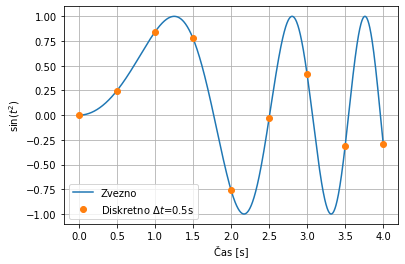

In [17]:
import numpy as np
import matplotlib.pyplot as plt


# na računalniku zvezne časovne vrste dejansko ne moremo generirati
# "zvezna" bo samo dosti bolj gosta
t, dt = np.linspace(0,4,1000, retstep=True)
t2, dt2 = np.linspace(0,4,9, retstep=True)

plt.plot(t, np.sin(t**2), label='Zvezno') 
plt.plot(t2, np.sin(t2**2), 'o',label='Diskretno $\\Delta t$=0.5s')
plt.xlabel('Čas [s]')
plt.ylabel('$\\sin(t^2)$')
plt.grid()
plt.legend();

## Klasifikacija podatkov

Klasifikacija podatkov (prirejeno po {cite:t}`bendat_2011,shin2008`) je prikazana na spodnji sliki.

![klasifikacija_podatkov](./images/klasifikacija_podatkov.svg)

Podatke najprej delimo na:
* **deterministične** (kdaj slišimo tudi *določljivostne*) to so podatki, ki imajo vrednosti v času enolično določene in
* **naključne** kjer vrednosti v nekem trenutku ekzaktno ne vemo, je pa ta lahko določena z verjetnostno porazdelitvijo.

Primer determinističnih podatkov je funkcija:

$$
x(t) = \sin(t),
$$

primer naključnih pa višina gladine razburkanega morja. Pri klasifikaciji podatkov ne smemo pozabiti, da imamo lahko podatke sestavljene iz determinističnega in naključnega dela.

Spodja slika prikazuje periodične podatke, najprej je prikazan trikotni signal, ki se ponavlja s periodo 1s, nato je prikazan harmonski signal, ki se prav tako ponavlja s periodo 1s. Zadnji signal predstavlja kompleksno periodične podatke, ki so sestavljeni kot vsota več harmonskih komponent, perioda tega na sliki je 2s.

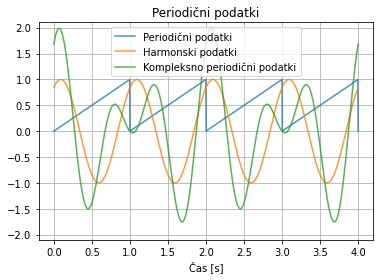

In [38]:
import numpy as np
import matplotlib.pyplot as plt


t, dt = np.linspace(0,4,1000, retstep=True)

plt.title('Periodični podatki')
plt.plot(t, t%1, label='Periodični podatki', alpha=0.8) 
plt.plot(t, np.sin(2*np.pi*t+1), label='Harmonski podatki', alpha=0.8) 
plt.plot(t, np.sin(2*np.pi*t+1)+np.sin(3*np.pi*t+1), label='Kompleksno periodični podatki', alpha=0.8)
plt.ylim(-2.1,2.1)
plt.xlabel('Čas [s]')
plt.grid()
plt.legend();

Pri neperiodični podatkih, bomo spodaj prikazali prehodne podatke, ki npr. nastanejo, ko dinamski sistem vzbudimo z impulzno motnjo in le-ta nato izniha. Kaotičnih neperiodičnih tukaj ne bomo podrobneje obravnavali, zanje velja, da jih zaradi visoke stopnje dinamičnosti lahko zanesljivo napovedujemo samo za relativno kratek čas v naprej, potem pa se njihovo obnašanje zdi čedalje bolj naključno.

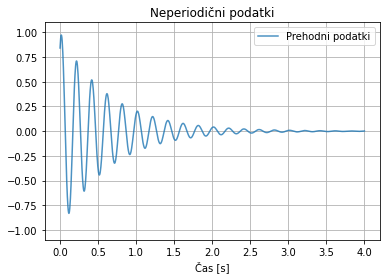

In [40]:
import numpy as np
import matplotlib.pyplot as plt


t, dt = np.linspace(0,4,1000, retstep=True)
omega = 10*np.pi
dušenje = 0.05

plt.title('Neperiodični podatki')

plt.plot(t, np.exp(-omega*dušenje*t)*np.sin(omega*t+1), label='Prehodni podatki', alpha=0.8) 
plt.ylim(-1.1,1.1)
plt.xlabel('Čas [s]')
plt.grid()
plt.legend();

Tukaj je potrebno povezati vsa poglavja, ki sledijo. Narediti pregle. To se bo naredilo na koncu.

Povezati je treba termine kot so:
* proces
* sistem
* linearni časovno neodvisni sistem
* impulzni odziv
* konvolucija
* Fourierjeva transformacija
* časovna ali frekvenčna domena
* naključni ali deterministični proces

Signal processing deals with the analysis of processes which can in general be [**deterministic**](sec:deterministic) or  [**random**](sec:random). Deterministic process is the process that can (with a reasonable accuracy) be described with an explicit mathematical relation. Random process is a process than cannot be described with an explicit mathematical relation, but requires probability statements and statistical averages.

This chapter will give a general introduction which is required for the following chapters. Greater details can be found in books by {cite:t}`bendat_piersol_random_data_2010`, {cite:t}`shin2008fundamentals`, {cite:t}`newland_1993` and {cite:t}`rice1944mathematical`.

(sec:deterministic)=
## Deterministic process

Deterministic data from a deterministic process is that which can be unambiguously deduced through mathematical relationships and conditions. Values within the sequence, such as a time history, can be successfully extrapolated or predicted, to at least within the tolerable error margin. When considering for instance the measured data from a deterministic dynamic system it is expected that, under equal conditions, the observed repeated system response will always be equal, as is, for example, for a mathematical pendulum, released from the same height.
